<a href="https://colab.research.google.com/github/vasighiz/bio-dl-test/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Part 1: Scanpy-based scRNA-seq Analysis

In [1]:
pip install scanpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00


In [2]:
pip install igraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.7 MB/s eta 0:00:00


In [3]:
pip install leidenalg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.8 MB/s eta 0:00:00


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt

In [4]:
# Load dataset
adata = sc.datasets.pbmc3k()
adata = adata[:300]  # Subsample for speed

In [5]:
# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [6]:
# PCA, neighbors, UMAP
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<ipython-input-7-4c8716ee354e>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


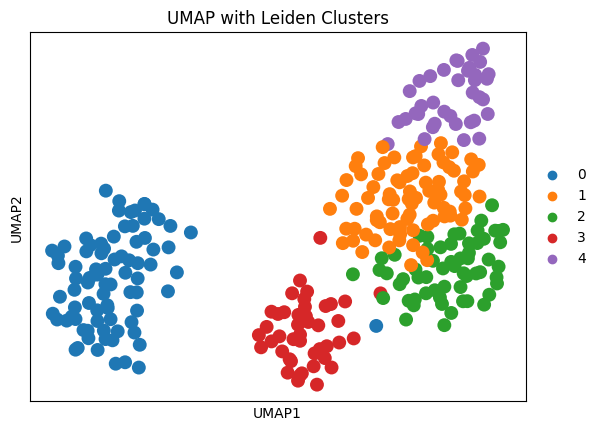

In [7]:
# Clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], title='UMAP with Leiden Clusters')

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


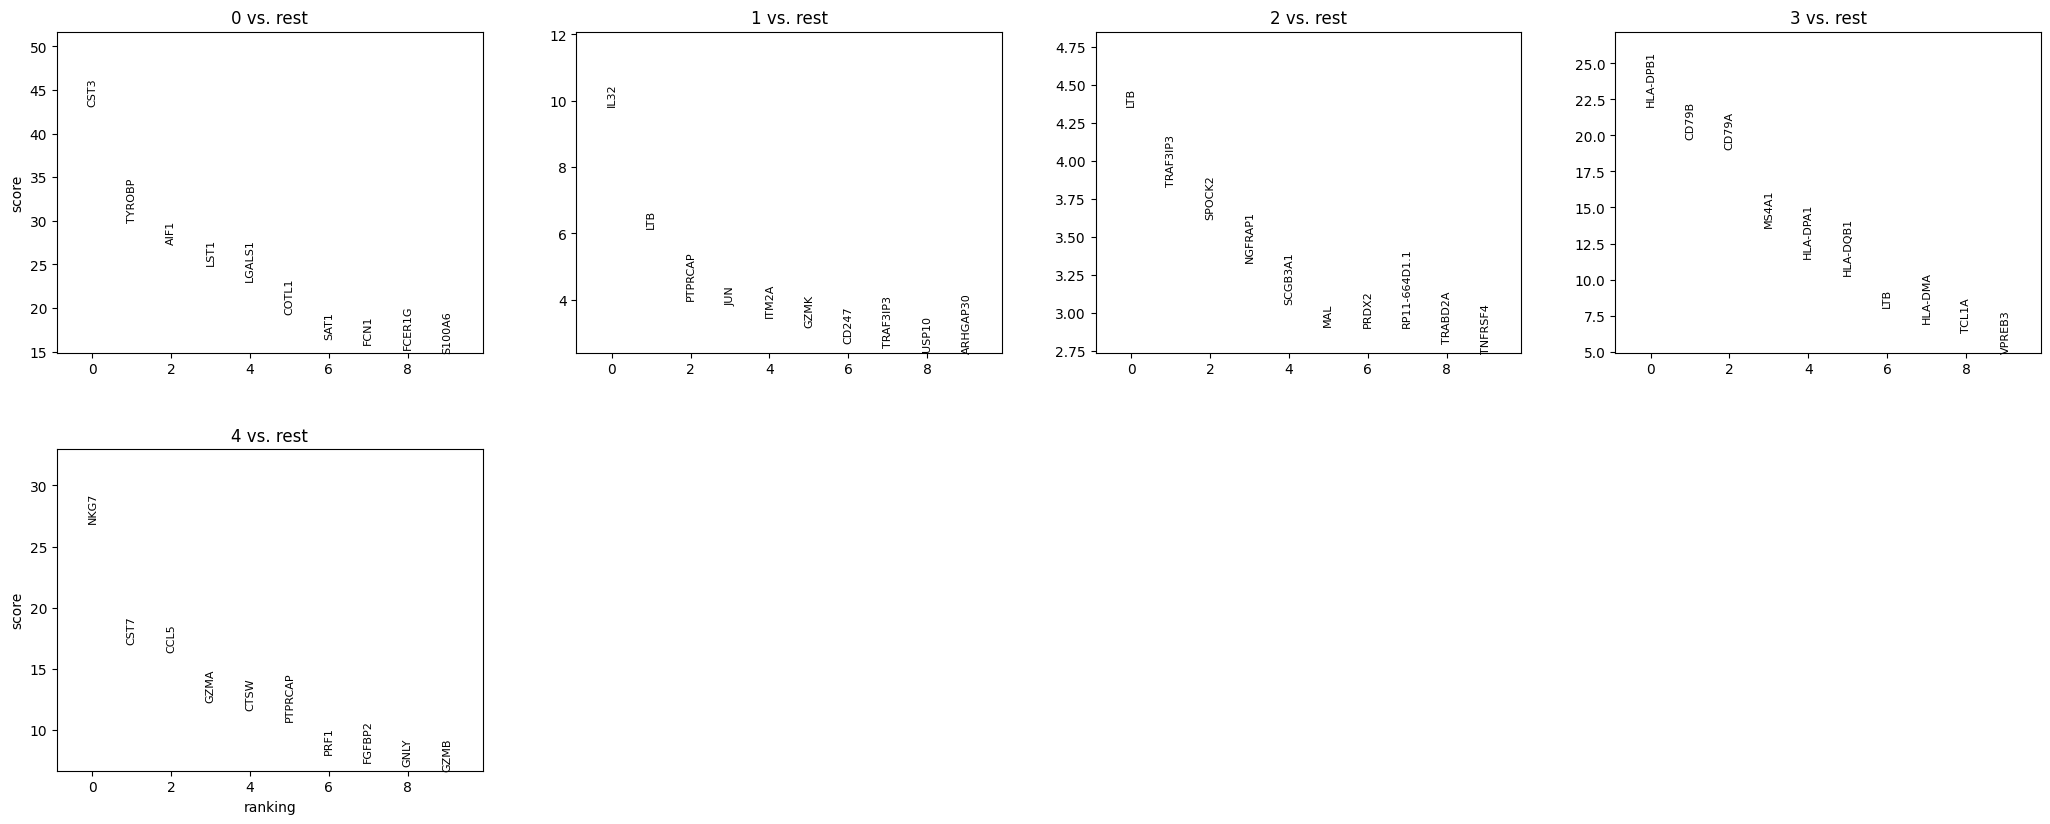

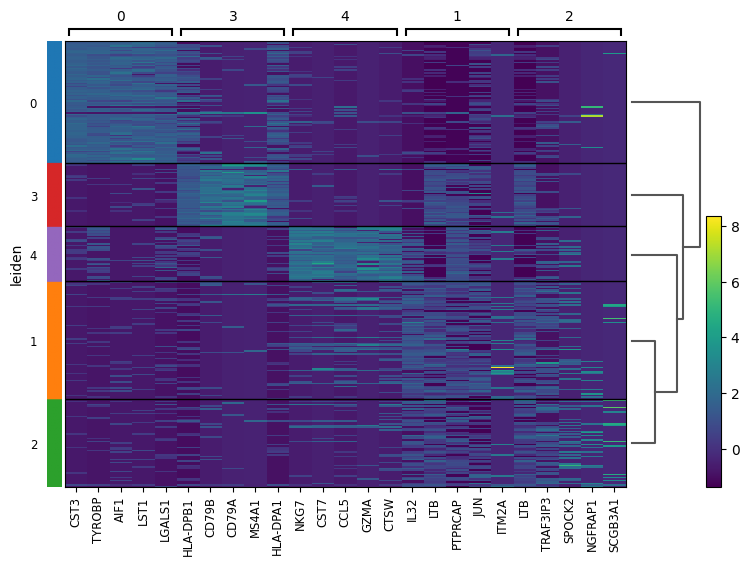

In [8]:
# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='leiden', show=True)

**Interpretation:** The clusters represent different immune cell types in PBMCs. The UMAP plot shows clear separations, and marker gene heatmap provides top markers per cluster.

## Part 2a: Deep Learning - PyTorch Autoencoder

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

In [22]:
# Prepare data
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [23]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

model = Autoencoder(X_tensor.shape[1], 10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [24]:
# Train
for epoch in range(100):
    optimizer.zero_grad()
    out, _ = model(X_tensor)
    loss = loss_fn(out, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0114
Epoch 20, Loss: 1.0001
Epoch 40, Loss: 0.9900
Epoch 60, Loss: 0.9784
Epoch 80, Loss: 0.9675


In [25]:
# Extract latent space
_, latent = model(X_tensor)
latent_np = latent.detach().numpy()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


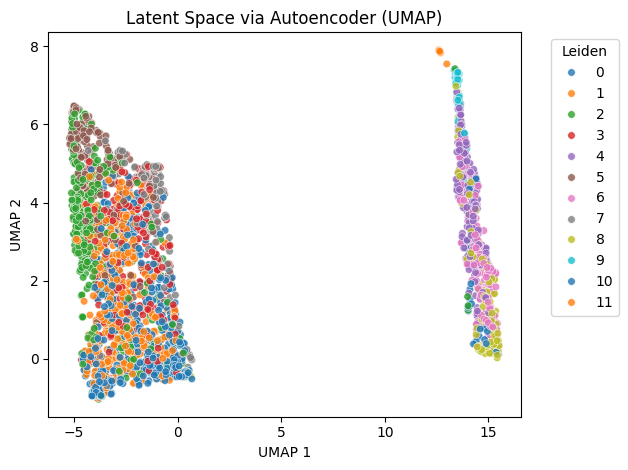

In [26]:
# Apply UMAP to the latent space
reducer = umap.UMAP(n_components=2, random_state=42)
latent_umap = reducer.fit_transform(latent_np)

# Visualize with UMAP
sns.scatterplot(x=latent_umap[:, 0], y=latent_umap[:, 1],
                hue=adata.obs['leiden'], palette='tab10', s=30, alpha=0.8)
plt.title("Latent Space via Autoencoder (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Leiden', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


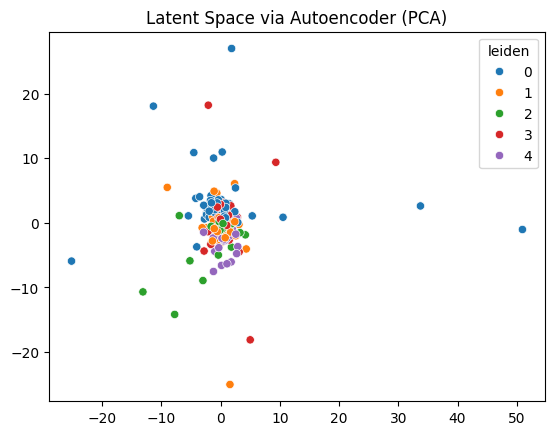

In [15]:
# Visualize with PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_np)
sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=adata.obs['leiden'], palette='tab10')
plt.title("Latent Space via Autoencoder (PCA)")
plt.show()

##  Part 2b: Deep Learning - scVI Variational Autoencoder

In [20]:
!pip uninstall -y jax jaxlib
!pip install jaxlib --quiet
!pip uninstall -y scvi scvi-tools
!pip install --quiet --upgrade scvi-tools

Found existing installation: jax 0.4.35
Uninstalling jax-0.4.35:
  Successfully uninstalled jax-0.4.35
Found existing installation: jaxlib 0.4.35
Uninstalling jaxlib-0.4.35:
  Successfully uninstalled jaxlib-0.4.35


In [1]:
import scvi
from scvi.model import SCVI

/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/50 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


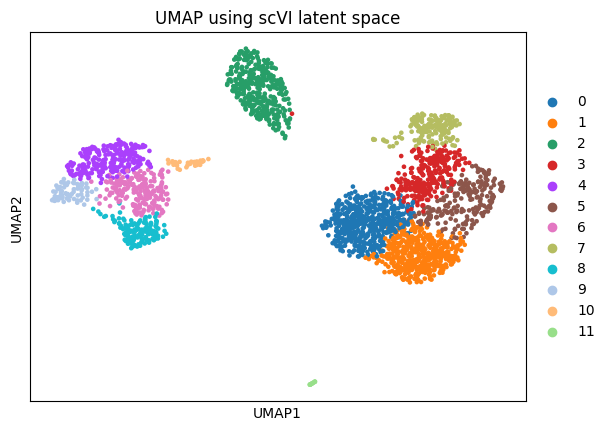

In [18]:
import scanpy as sc
import scvi

# Load PBMC dataset and subset for quick testing
adata = sc.datasets.pbmc3k()
adata = adata.raw.to_adata() if adata.raw else adata.copy()

# IMPORTANT: scvi expects raw counts, so don't normalize or log
# Remove cells/genes with zero total counts
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_genes(adata, min_counts=1)

# Setup for scvi
scvi.model.SCVI.setup_anndata(adata)

# Train model
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=50)

# Get latent space and visualize
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden", title="UMAP using scVI latent space")


##  Part 3: Multi-Omics Integration

**Two Strategies for Integration:**
1. Early Integration (Concatenation): Combine features before model input.
2. Late Integration (Ensemble): Separate models for each omic type, combine outputs.

**Minimal Code for Concatenation:**
```python
rna = adata.layers['rna']
protein = adata.obsm['protein']
combined = np.concatenate([rna, protein], axis=1)
```

##  Part 4: Scientific Reasoning

**3 Possible Causes of Poor Clustering:**
1. Inadequate normalization or preprocessing
2. Too few PCs or wrong neighborhood parameters
3. Biologically similar cells genuinely hard to distinguish

**2 Suggestions:**
- Increase resolution or try alternative clustering
- Use more robust latent space (e.g., scVI or Harmony)

**Abstract:**
We performed a comprehensive analysis of PBMC single-cell transcriptomic data using Scanpy and deep learning approaches. Our preprocessing and clustering pipeline revealed distinct immune cell populations. An autoencoder and scVI model were trained to reduce dimensionality and capture meaningful latent representations. Integration strategies and biological interpretation were explored, highlighting the value of generative AI in single-cell omics.